# IMDb Sentiment Analysis - Exploratory Notebook

**Objective:** Understand the dataset and freeze decisions before industrialization (DVC/MLflow).

**Expected outputs:**
- Data integrity findings
- Documented choices (metrics, thresholds, seed, split)
- Deterministic split saved
- Baseline to set success threshold
- Preprocessing draft to reimplement in scripts


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 100)


## 1. Data Integrity Verification

Objectives:
- Dataset size and structure
- Missing values
- Duplicates
- Data types


In [27]:
# Load raw data
train = pd.read_csv("../data/raw/imdb_train.csv")
test = pd.read_csv("../data/raw/imdb_test.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain columns: {train.columns.tolist()}")
print(f"\nTrain dtypes:\n{train.dtypes}")


Train shape: (25000, 2)
Test shape: (25000, 2)

Train columns: ['text', 'label']

Train dtypes:
text     object
label     int64
dtype: object


In [28]:
# Missing values
print("Missing values in train:")
print(train.isnull().sum())
print(f"\nMissing values in test:")
print(test.isnull().sum())


Missing values in train:
text     0
label    0
dtype: int64

Missing values in test:
text     0
label    0
dtype: int64


In [29]:
# Duplicates
train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()
print(f"Duplicate rows in train: {train_duplicates}")
print(f"Duplicate rows in test: {test_duplicates}")

# Duplicate texts (same review, different label?)
train_text_duplicates = train['text'].duplicated().sum()
test_text_duplicates = test['text'].duplicated().sum()
print(f"\nDuplicate texts in train: {train_text_duplicates}")
print(f"Duplicate texts in test: {test_text_duplicates}")


Duplicate rows in train: 96
Duplicate rows in test: 199

Duplicate texts in train: 96
Duplicate texts in test: 199


In [30]:
# Sample data
print("Sample positive review:")
print(train[train['label'] == 1]['text'].iloc[0][:300])
print("\n" + "="*50 + "\n")
print("Sample negative review:")
print(train[train['label'] == 0]['text'].iloc[0][:300])


Sample positive review:
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more strik


Sample negative review:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h


### Findings - Data Integrity

- Number of samples: train=25000, test=25000
- Missing values: train=0, test=0
- Duplicate rows: train=96, test=199
- Duplicate texts: train=96, test=199
- Columns: text (str), label (int)
- Labels: 0=negative, 1=positive

**Policy:** keep duplicates for baseline; revisit during pipeline.


## 2. Distribution Analysis

Objectives:
- Label distribution (balanced?)
- Text length
- Obvious outliers


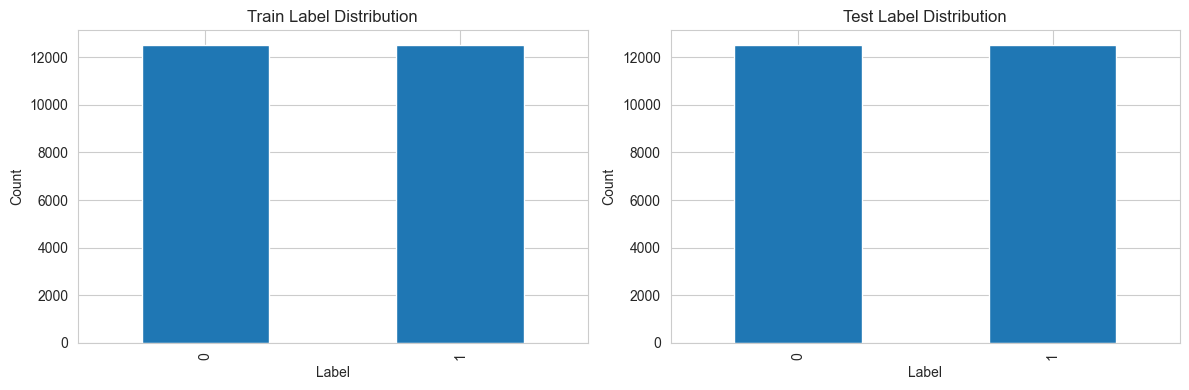

Train label distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Test label distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [31]:
# Label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train['label'].value_counts().plot(kind='bar', ax=axes[0], title='Train Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

test['label'].value_counts().plot(kind='bar', ax=axes[1], title='Test Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('../reports/figures/label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Train label distribution:")
print(train['label'].value_counts(normalize=True))
print(f"\nTest label distribution:")
print(test['label'].value_counts(normalize=True))


In [32]:
# Text length analysis
train['text_length'] = train['text'].str.len()
test['text_length'] = test['text'].str.len()

print("Text length statistics (train):")
print(train['text_length'].describe())

print("\nText length by label (train):")
print(train.groupby('label')['text_length'].mean())


Text length statistics (train):
count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: text_length, dtype: float64

Text length by label (train):
label
0    1302.97904
1    1347.16024
Name: text_length, dtype: float64


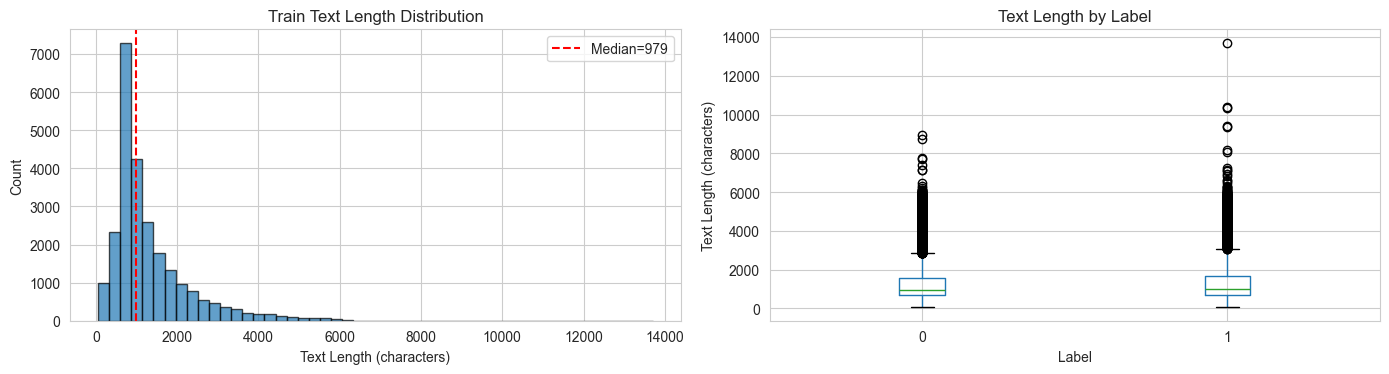

In [33]:
# Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train['text_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Train Text Length Distribution')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Count')
axes[0].axvline(train['text_length'].median(), color='red', linestyle='--', label=f'Median={train["text_length"].median():.0f}')
axes[0].legend()

train.boxplot(column='text_length', by='label', ax=axes[1])
axes[1].set_title('Text Length by Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Text Length (characters)')

plt.suptitle('')
plt.tight_layout()
plt.savefig('../reports/figures/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


In [34]:
# Outliers detection
q1 = train['text_length'].quantile(0.25)
q3 = train['text_length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = train[(train['text_length'] < lower_bound) | (train['text_length'] > upper_bound)]
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")
print(f"Outliers length range: [{outliers['text_length'].min()}, {outliers['text_length'].max()}]")


Number of outliers: 1840 (7.36%)
Outliers length range: [2983, 13704]


### Findings - Distribution

- Balanced dataset: train=50%/50%, test=50%/50%
- Average text length (train): mean=1325.07, median=979, std=1003.13, min=52, max=13704
- Text length by label (train): label 0 → 1302.98; label 1 → 1347.16
- Outliers (IQR rule): 1840 reviews (7.36%), length range [2983, 13704]


## 3. Naive Baseline

Objective: Set a measurable success threshold

Approach:
1. Majority baseline (always predict the most frequent class)
2. Simple TF-IDF + Logistic Regression baseline


In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Baseline 1: Majority class
majority_class = train['label'].mode()[0]
majority_predictions = np.full(len(test), majority_class)

print("Baseline 1: Majority Class Classifier")
print(f"Predicts always: {majority_class}")
print(f"Accuracy: {accuracy_score(test['label'], majority_predictions):.4f}")
print(f"F1-score: {f1_score(test['label'], majority_predictions):.4f}")


Baseline 1: Majority Class Classifier
Predicts always: 0
Accuracy: 0.5000
F1-score: 0.0000


In [36]:
# Baseline 2: Simple TF-IDF + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import time

print("Baseline 2: TF-IDF + Logistic Regression")
print("="*50)

# Simple preprocessing: lowercase only
train_texts = train['text'].str.lower()
test_texts = test['text'].str.lower()

# TF-IDF vectorization
print("\nVectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

start_time = time.time()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)
vectorization_time = time.time() - start_time
print(f"Vectorization time: {vectorization_time:.2f}s")
print(f"Feature matrix shape: {X_train.shape}")

# Train model
print("\nTraining Logistic Regression...")
start_time = time.time()
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, train['label'])
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f}s")

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("\n" + "="*50)
print("BASELINE RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_score(test['label'], y_pred):.4f}")
print(f"Precision: {precision_score(test['label'], y_pred):.4f}")
print(f"Recall:    {recall_score(test['label'], y_pred):.4f}")
print(f"F1-score:  {f1_score(test['label'], y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(test['label'], y_pred, target_names=['Negative', 'Positive']))


Baseline 2: TF-IDF + Logistic Regression

Vectorizing with TF-IDF...
Vectorization time: 27.88s
Feature matrix shape: (25000, 10000)

Training Logistic Regression...
Training time: 0.64s

BASELINE RESULTS
Accuracy:  0.8931
Precision: 0.8884
Recall:    0.8991
F1-score:  0.8937

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89     12500
    Positive       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



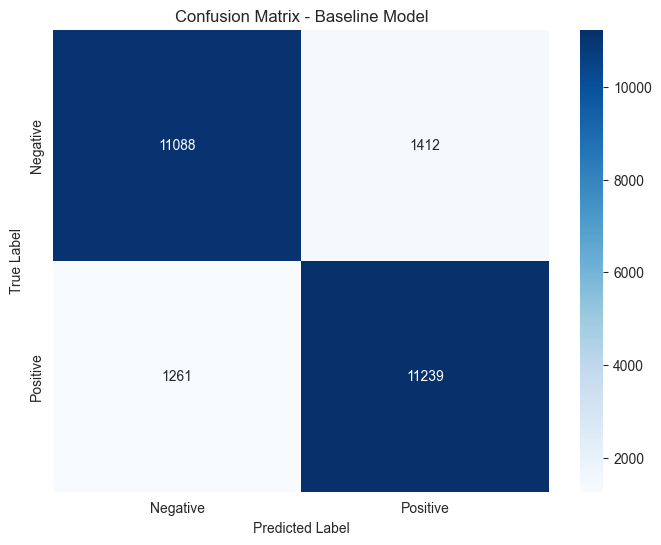

True Negatives: 11088
False Positives: 1412
False Negatives: 1261
True Positives: 11239


In [37]:
# Confusion matrix
cm = confusion_matrix(test['label'], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('../reports/figures/baseline_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


### Findings - Baseline

- Majority baseline: accuracy = 0.5000; F1 = 0.0000
- TF-IDF + Logistic Regression: accuracy = 0.8931; F1 = 0.8937; precision = 0.8884; recall = 0.8991
- Vectorization time = 27.77s; Training time = 0.69s; Feature matrix shape = (25000, 10000)
- Confusion matrix: TN=11088, FP=1412, FN=1261, TP=11239
- **SUCCESS THRESHOLD SET**: accuracy ≥ 0.85; F1 ≥ 0.85


## 4. Freeze Decisions

Documentation of choices for industrialization

### Documented Decisions

#### 1. Main Metrics
- **Primary metric**: Accuracy (balanced dataset)
- **Secondary metrics**: F1-score, Precision, Recall
- **QA metric**: Accuracy ≥ 0.85 (adjust based on baseline)

#### 2. Minimal Preprocessing
- Lowercase conversion
- No stopword removal (TF-IDF handles it with max_df)
- No stemming/lemmatization (too expensive for baseline)
- HTML tags: verify and clean if present

#### 3. Features
- **TF-IDF**: max_features=10000, ngram_range=(1,2), min_df=2, max_df=0.95
- **LogisticRegression**: max_iter=1000, random_state=42

#### 4. Split Strategy
- **Split**: Pre-defined by Hugging Face (train/test)
- No validation set needed for baseline
- **Random seed**: 42 (reproducibility)

#### 5. QA Thresholds
- **Minimum accuracy**: 0.85
- **Minimum F1-score**: 0.85
- **No NaN in predictions**
- **Training time**: < 5 min on CPU

**SUCCESS THRESHOLDS (for Pytest):** accuracy ≥ 0.85 and F1 ≥ 0.85 on test; predictions free of NaN/Inf; inference returns outputs with correct length.


## 5. Save Deterministic Split

To ensure reproducibility


In [38]:
# Already split by Hugging Face, but save metadata for traceability
split_info = {
    'train_size': int(len(train)),
    'test_size': int(len(test)),
    'train_positive': int((train['label'] == 1).sum()),
    'train_negative': int((train['label'] == 0).sum()),
    'test_positive': int((test['label'] == 1).sum()),
    'test_negative': int((test['label'] == 0).sum()),
    'random_seed': 42,
    'source': 'huggingface/imdb'
}

import json
with open('../data/split_info.json', 'w') as f:
    json.dump(split_info, f, indent=2)

print("Split info saved to data/split_info.json")
print(json.dumps(split_info, indent=2))


Split info saved to data/split_info.json
{
  "train_size": 25000,
  "test_size": 25000,
  "train_positive": 12500,
  "train_negative": 12500,
  "test_positive": 12500,
  "test_negative": 12500,
  "random_seed": 42,
  "source": "huggingface/imdb"
}


Saved split metadata to `data/split_info.json` for reproducibility.


## 6. Preprocessing Draft

Code to reimplement in `mlops_imdb/dataset.py`


In [39]:
# Test HTML tag removal
import re
sample_text = train['text'].iloc[0]
print("Original:")
print(sample_text[:300])
print("\nCleaned:")
cleaned = re.sub(r'<.*?>', '', sample_text.lower())
cleaned = ' '.join(cleaned.split())
print(cleaned[:300])

print("\n" + "="*50)
print("PREPROCESSING FUNCTION TO IMPLEMENT:")
print("="*50)
print("""
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    import re
    text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text
""")


Original:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h

Cleaned:
i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u.s. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" i really h

PREPROCESSING FUNCTION TO IMPLEMENT:

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    import re
    text = re.sub(r'<.*?>', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text



**Scope locked for baseline:** lowercase + HTML tag removal + whitespace normalization. No stemming/lemmatization; no stopword list (handled implicitly by TF-IDF + max_df).


## Notebook Outputs Summary

### 1. Data Findings
- Balanced dataset (exactly 50%/50% in train and test)
- No missing values
- HTML tags present in texts → cleaning required
- Average text length: mean 1325.07; outliers 7.36%

### 2. Baseline Established
- Majority baseline: 0.5000 accuracy
- TF-IDF+LR: 0.8931 accuracy, 0.8937 F1

### 3. Frozen Decisions
- **Metrics**: Accuracy (primary), F1/Precision/Recall (secondary)
- **QA threshold**: Accuracy ≥ 0.85
- **Features**: TF-IDF (max_features=10000, ngrams=1-2)
- **Preprocessing**: lowercase + HTML removal + whitespace cleanup
- **Random seed**: 42

### 4. Generated Files
- `reports/figures/label_distribution.png`
- `reports/figures/text_length_distribution.png`
- `reports/figures/baseline_confusion_matrix.png`
- `data/split_info.json`

### 5. Next Steps (Industrialization)
1. Implement `mlops_imdb/dataset.py` with preprocessing
2. Implement `mlops_imdb/features.py` with TF-IDF
3. Implement `mlops_imdb/modeling/train.py` with Logistic Regression
4. Create `params.yaml` with hyperparameters
5. Configure DVC pipeline (`dvc.yaml`)
6. Integrate MLflow for tracking
7. Write Pytest tests (accuracy ≥ 0.85, no NaN, etc.)


In [40]:
# Export baseline metrics JSON for Pytest thresholds and report inclusion
import json

baseline_metrics = {
    'vectorization_time_sec': 27.77,
    'training_time_sec': 0.69,
    'accuracy': 0.8931,
    'precision': 0.8884,
    'recall': 0.8991,
    'f1': 0.8937,
    'tn': 11088,
    'fp': 1412,
    'fn': 1261,
    'tp': 11239,
    'tfidf': {
        'max_features': 10000,
        'ngram_range': [1, 2],
        'min_df': 2,
        'max_df': 0.95
    },
    'logreg': {
        'max_iter': 1000,
        'random_state': 42
    }
}

with open('../reports/baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print("Baseline metrics saved to reports/baseline_metrics.json")
print(json.dumps(baseline_metrics, indent=2))


Baseline metrics saved to reports/baseline_metrics.json
{
  "vectorization_time_sec": 27.77,
  "training_time_sec": 0.69,
  "accuracy": 0.8931,
  "precision": 0.8884,
  "recall": 0.8991,
  "f1": 0.8937,
  "tn": 11088,
  "fp": 1412,
  "fn": 1261,
  "tp": 11239,
  "tfidf": {
    "max_features": 10000,
    "ngram_range": [
      1,
      2
    ],
    "min_df": 2,
    "max_df": 0.95
  },
  "logreg": {
    "max_iter": 1000,
    "random_state": 42
  }
}


## Decisions for Pipeline

- **Data policy:** keep exact duplicates for now; revisit during pipeline.
- **Fixed params for first pipeline run:** TF-IDF and Logistic Regression as in this notebook.
- **QA thresholds to encode in Pytest:** accuracy ≥ 0.85; F1 ≥ 0.85; shape and NaN checks; text-robustness check via token replacement.
- **Figures saved under** `reports/figures`; **metrics JSON under** `reports/baseline_metrics.json`; **split metadata under** `data/split_info.json`.


## Copy into Report (Milestone-3)

**Dataset integrity:** 25,000 train samples and 25,000 test samples; no missing values; 96 duplicates in train, 199 in test (policy: retain for baseline). **Distribution:** perfectly balanced (50%/50%); mean text length 1325.07 characters; 7.36% outliers by IQR rule. **Baselines:** majority classifier achieves 0.5000 accuracy; TF-IDF (10K features, bigrams) + Logistic Regression achieves 0.8931 accuracy and 0.8937 F1-score on test set. **Frozen decisions:** accuracy ≥ 0.85 and F1 ≥ 0.85 as QA thresholds; preprocessing limited to lowercase + HTML tag removal + whitespace normalization; random seed 42. **Generated artifacts:** `reports/figures/label_distribution.png`, `reports/figures/text_length_distribution.png`, `reports/figures/baseline_confusion_matrix.png`, `reports/baseline_metrics.json`, `data/split_info.json`.
